In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Environment SETUP**

In [2]:
!python3 -m pip install pyyaml==5.1
import sys, os, distutils.core
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 6.2 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15508, done.
remote: Counting objects: 100% (233/233), done.
remote: Compressing objects: 100% (191/191), done.
remote: Total 15508 (delta 66), reused 178 (delta 42), pack-reused 15275
Receiving objects: 100% (15508/15508), 6.39 MiB | 13.21 MiB/s, done.
Resolving deltas: 100% (11181/11181), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.1 MB/s eta 0:00:

## **Importing required libraries**

In [3]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.1 ; cuda:  cu121
detectron2: 0.6


In [34]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [35]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode

## **Dataset registration**

In [36]:
def get_sign_dicts(directory):
    classes = ['leopard']
    dataset_dicts = []
    img_id = 0
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            # print('opened file')
            img_anns = json.load(f)
            # print(img_anns['images'])
            # print(img_anns['file_name'])

        record = {}
        temp = img_anns['imagePath'].split('\\')
        # print(temp[-1])
        filename = os.path.join(directory, temp[-1])
        # filename = os.path.join(directory, img_anns["imagePath"])

        record["file_name"] = filename
        record["image_id"] = img_id
        record["height"] = img_anns["imageHeight"]
        record["width"] = img_anns["imageWidth"]

        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']]
            py = [a[1] for a in anno['points']]
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
        img_id += 1
    return dataset_dicts

In [7]:
# temp_dict = get_sign_dicts('/content/drive/MyDrive/Leopard_dataset/train')

In [9]:
# temp_dict

In [37]:
for d in ["train", "val"]:
    DatasetCatalog.register("leopard_segmentation_test2_" + d, lambda d=d: get_sign_dicts('/content/drive/MyDrive/Leopard_dataset/' + d))
    MetadataCatalog.get("leopard_segmentation_test2_" + d).set(thing_classes=['Leopard'])


In [38]:
leopard_segmentation_test2_metadata = MetadataCatalog.get("leopard_segmentation_test1_train")

## **Training and Visualization**

In [39]:
dataset_dicts = get_sign_dicts("/content/drive/MyDrive/Leopard_dataset/train")

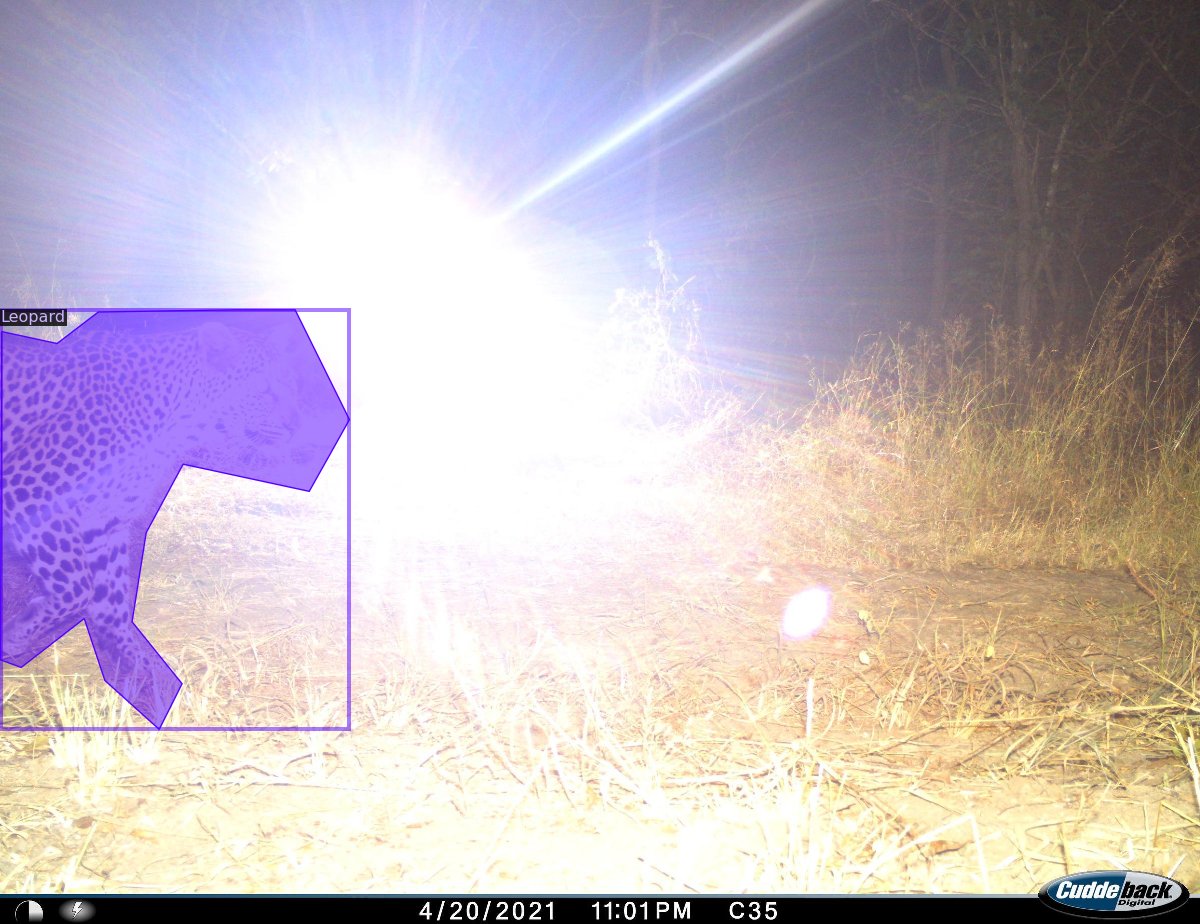

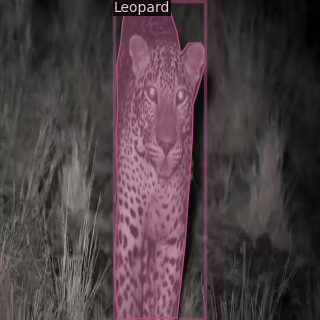

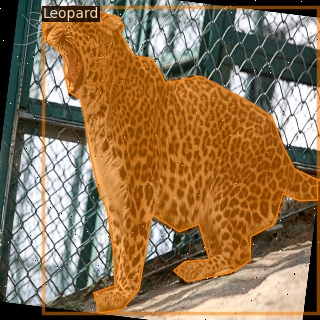

In [40]:
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=leopard_segmentation_test2_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [41]:
len(dataset_dicts)

597

In [33]:
# for i in range(len(dataset_dicts)):
#     if len(dataset_dicts[i]["annotations"][0]['segmentation'][0]) == 4:
#         print("instance number", i, "raises arror:",dataset_dicts[i]["annotations"][0]['segmentation'][0])
#         print(dataset_dicts[i]['file_name'])

In [30]:
# dataset_dicts[0]['file_name']

'/content/drive/MyDrive/Leopard_dataset/train/114.jpg'

In [42]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("leopard_segmentation_test1_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
# cfg.INPUT.MASK_FORMAT = "bitmask"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[03/13 17:06:54 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[03/13 17:06:57 d2.engine.train_loop]: Starting training from iteration 0
[03/13 17:07:07 d2.utils.events]:  eta: 0:07:44  iter: 19  total_loss: 1.512  loss_cls: 0.6581  loss_box_reg: 0.1299  loss_mask: 0.6957  loss_rpn_cls: 0.002968  loss_rpn_loc: 0.008051    time: 0.4856  last_time: 0.4469  data_time: 0.0214  last_data_time: 0.0083   lr: 4.9953e-06  max_mem: 3696M
[03/13 17:07:18 d2.utils.events]:  eta: 0:07:55  iter: 39  total_loss: 1.416  loss_cls: 0.5779  loss_box_reg: 0.1668  loss_mask: 0.6882  loss_rpn_cls: 0.001486  loss_rpn_loc: 0.005471    time: 0.4992  last_time: 0.6769  data_time: 0.0114  last_data_time: 0.0279   lr: 9.9902e-06  max_mem: 3696M
[03/13 17:07:27 d2.utils.events]:  eta: 0:07:33  iter: 59  total_loss: 1.239  loss_cls: 0.4262  loss_box_reg: 0.1472  loss_mask: 0.6666  loss_rpn_cls: 0.00122  loss_rpn_loc: 0.004198    time: 0.4924  last_time: 0.5116  data_time: 0.0111  last_data_time: 0.0085   lr: 1.4985e-05  max_mem: 3696M
[03/13 17:07:37 d2.utils.events]:  eta: 0:

In [43]:
torch.save(trainer.model.state_dict(), os.path.join(cfg.OUTPUT_DIR, "model.pth"))

In [44]:
from google.colab import files

files.download(os.path.join(cfg.OUTPUT_DIR,"model.pth"))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Validation**

In [45]:
from detectron2.utils.visualizer import ColorMode

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3
cfg.DATASETS.TEST = ("leopard_segmentation_test2_val", )
predictor = DefaultPredictor(cfg)

[03/13 17:39:50 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model.pth ...


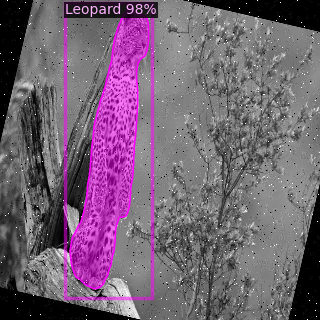

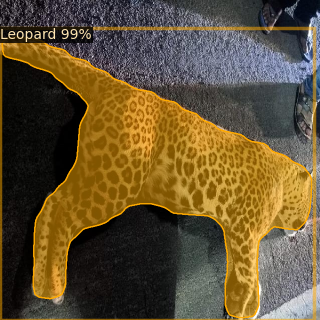

In [46]:
import matplotlib.pyplot as plt


dataset_dicts = get_sign_dicts('/content/drive/MyDrive/Leopard_dataset/val')
for d in random.sample(dataset_dicts, 2):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=leopard_segmentation_test2_metadata,
                   scale=0.5,
                  #  instance_mode=ColorMode.IMAGE_BW
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [47]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("leopard_segmentation_test2_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "leopard_segmentation_test2_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[03/13 17:42:01 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[03/13 17:42:01 d2.evaluation.coco_evaluation]: Trying to convert 'leopard_segmentation_test2_val' to COCO format ...
[03/13 17:42:01 d2.data.datasets.coco]: Converting annotations of dataset 'leopard_segmentation_test2_val' to COCO format ...)
[03/13 17:42:02 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[03/13 17:42:02 d2.data.datasets.coco]: Conversion finished, #images: 150, #annotations: 155
[03/13 17:42:02 d2.data.datasets.coco]: Caching COCO format annotations at './output/leopard_segmentation_test2_val_coco_format.json' ...
[03/13 17:42:03 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  Leopard   | 155          |
|            |              |
[03/13 17:42:03 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length